## 개념 및 특징
* LangGraph에서 실제 작업을 수행하는 기본 실행 단위
* 각 노드는 그래프의 한 단계를 나타내며, 데이터를 처리하고 반환하는 역할 수행

**핵심 특징**
* 함수 기반: Python 함수로 구현
* 상태 중심: 현재 상태를 입력으로 받아 처리
* 독립적 실행: 각 노드는 독립적으로 실행 가능
* 조합 가능: 여러 노드를 연결하여 복잡한 워크플로우 구성

**주요 설계 특징 및 장점**
* **모듈성과 재사용성**
  * 명확한 입출력을 가진 독립적인 단위로 설계되어 다른 그래프나 워크플로우에서 쉽게 재사용할 수 있음
* **타입 안전성**
  * `TypedDict`를 활용한 상태 스키마를 통해 개발 단계에서 오류를 방지하고 유지보수를 용이하게 함
* **유연한 상태 업데이트**
  * 단순 덮어쓰기 외에 `Reducer`를 사용하여 복잡한 상태 병합 로직을 구현할 수 있음


In [1]:
# Basic Node Structure

from typing import TypedDict, Dict, Any
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState
# Init state
class State(MessagesState):
    counter: int
    status: str
    
# Basic Node Function
def increment(state):
    """
    가장 간단한 형태의 노드, 카운터 값을 받아서 1 증가시키는 함수

    Args:
        state: 현재 그래프의 상태
    """
    # 현재 상태에서 카운터 값 가져오기
    counter = state['counter']
    
    # 함수 로직 수행
    new_counter = counter + 1
    
    # 업데이트된 상태 반환
    return {
        "counter": new_counter,
        "messages": f"Updated counter to {new_counter}",
        "status": "Incremented"
    }
    
# Add graph & node
_graph = StateGraph(State)
_graph.add_node("increment", increment) # 노드 이름과 함수 매핑해야함

In [2]:
# Standard Node I/O Pattern

def standard_node(state: State) -> Dict[str, Any]:
    """
    표준 노드 패턴

    입력: 전체 상태
    출력: 업데이트할 필드만 포함한 딕셔너리
    """
    # 1. 상태에서 필요한 데이터 추출
    input_data = state.get("input_field", "default_value")

    # 2. 처리 로직 수행
    processed_data = process_data(input_data)

    # 3. 업데이트할 필드만 반환
    # 반환하지 않은 필드는 그대로 유지됨
    return {
        "output_field": processed_data,
        "processed": True
    }

def process_data(data):
    """데이터 처리 로직"""
    return f"Processed: {data}"


## 핵심 역할
`확장 가능하고 유지보수가 용이한 아키텍처를 구축하는 데 핵심적인 독립적인 처리 단위`

* 정의
  * LangGraph 노드는 그래프 내에서 특정 작업을 수행하는 **독립적인 처리 단위**.
* **작동 방식**
  * 입력 상태를 받아 특정 로직을 실행하고, 그 결과를 다시 상태로 반환하는 **함수형 패러다임**
* **특징**
  * 모든 노드는 공통된 **상태 스키마**를 통해 데이터를 주고받으며, 복잡한 워크플로우에서도 일관된 데이터 흐름을 보장함

### 주요 책임
* **데이터 변환 및 처리**
  * 원시 데이터를 구조화하거나, 계산을 수행하거나, 외부 API와 통신하는 역할
* **상태 관리**
  * 애플리케이션의 현재 상태를 읽고 필요한 변경사항을 적용하고, 다음 단계로 전달할 정보를 준비
* **흐름 제어**
  * 조건부 로직을 통해 다음에 실행될 노드를 동적으로 결정하거나, 특정 조건에서 실행을 종료시킴

### 상태 처리 노드 구현

In [3]:
from datetime import datetime
from langgraph.graph import START,END
class DataState(TypedDict):
    raw_data: str
    processed_data: dict
    metadata: dict

def data_processor_node(state: DataState) -> Dict[str, Any]:
    """
    상태 처리 노드
    원시 데이터를 받아 구조화된 데이터로 변환
    """
    raw_data = state["raw_data"]

    # 데이터 파싱
    lines = raw_data.strip().split('\n')

    # 구조화
    processed = {
        "total_lines": len(lines),
        "content": lines,
        "first_line": lines[0] if lines else "",
        "last_line": lines[-1] if lines else ""
    }

    # 메타데이터 생성
    metadata = {
        "processed_at": datetime.now().isoformat(),
        "processor_version": "1.0.0",
        "data_size": len(raw_data)
    }

    return {
        "processed_data": processed,
        "metadata": metadata
    }

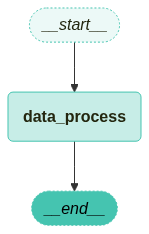

In [4]:
from langchain_teddynote.graphs import visualize_graph
# Initiate Graph add Nodes
_graph = StateGraph(DataState)
_graph.add_node('data_process',data_processor_node)
_graph.add_edge(START,"data_process")
_graph.add_edge("data_process",END)

# 그래프 시각화
graph = _graph.compile()
visualize_graph(graph)


In [5]:
# Execute Graph
from pprint import pprint
raw_data = """
안녕하세요 제 이름은 김청운 입니다.
오늘은 2025년 8월 20일 입니다.
"""
init_config = DataState(
    {
        "raw_data": raw_data,
        "processed_data": {},
        "metadata": {}
        }
)
result = graph.invoke(input = init_config)
pprint(result)

{'metadata': {'data_size': 44,
              'processed_at': '2025-08-20T19:07:41.614867',
              'processor_version': '1.0.0'},
 'processed_data': {'content': ['안녕하세요 제 이름은 김청운 입니다.',
                                '오늘은 2025년 8월 20일 입니다.'],
                    'first_line': '안녕하세요 제 이름은 김청운 입니다.',
                    'last_line': '오늘은 2025년 8월 20일 입니다.',
                    'total_lines': 2},
 'raw_data': '\n안녕하세요 제 이름은 김청운 입니다.\n오늘은 2025년 8월 20일 입니다.\n'}


### 로직 실행 노드 구현

In [6]:
class CalculationState(TypedDict):
    numbers: list[float]
    operation: str
    result: float
    history: list[dict]

def calculator_node(state: CalculationState) -> Dict[str, Any]:
    """
    비즈니스 로직 실행 노드
    수학 연산을 수행하고 결과를 저장
    """
    numbers = state["numbers"]
    operation = state["operation"]

    # 연산 수행
    if operation == "sum":
        result = sum(numbers)
    elif operation == "multiply":
        result = 1
        for num in numbers:
            result *= num
    elif operation == "average":
        result = sum(numbers) / len(numbers) if numbers else 0
    else:
        raise ValueError(f"Unknown operation: {operation}")

    # 히스토리 업데이트
    history_entry = {
        "operation": operation,
        "inputs": numbers,
        "result": result,
        "timestamp": datetime.now().isoformat()
    }

    return {
        "result": result,
        "history": [history_entry]  # 리듀서가 있다면 누적됨
    }

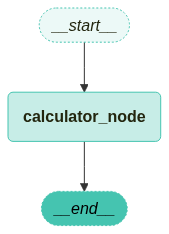

In [7]:
from langchain_teddynote.graphs import visualize_graph
# Initiate Graph add Nodes
_logic_graph = StateGraph(CalculationState)
_logic_graph.add_node('calculator_node',calculator_node)
_logic_graph.add_edge(START,"calculator_node")
_logic_graph.add_edge("calculator_node",END)

# 그래프 시각화
logic_graph = _logic_graph.compile()
visualize_graph(logic_graph)


In [8]:
# Execute Graph
from pprint import pprint
init_config = CalculationState(
    {
        "numbers": [1,2,3,4,5,6],
        "operation": "sum",
        "history": [],
        "result":0
    }
)
result = logic_graph.invoke(input = init_config)
pprint(result)

{'history': [{'inputs': [1, 2, 3, 4, 5, 6],
              'operation': 'sum',
              'result': 21,
              'timestamp': '2025-08-20T19:07:41.921288'}],
 'numbers': [1, 2, 3, 4, 5, 6],
 'operation': 'sum',
 'result': 21}


### 상태 업데이트 노드 구현

In [9]:
from typing import Annotated
import operator

class UpdateState(TypedDict):
    counter: int
    items: Annotated[list, operator.add]  # 리듀서 적용
    flags: dict

def update_node(state: UpdateState) -> Dict[str, Any]:
    """
    상태 업데이트 노드
    다양한 업데이트 패턴 시연
    """
    # 1. 단순 덮어쓰기
    new_counter = state["counter"] + 1

    # 2. 리스트에 추가 (리듀서 활용)
    new_items = ["new_item"]

    # 3. 딕셔너리 부분 업데이트
    updated_flags = state["flags"].copy()
    updated_flags["processed"] = True
    updated_flags["node_name"] = "update_node"

    return {
        "counter": new_counter,      # 덮어쓰기
        "items": new_items,          # 리듀서로 추가
        "flags": updated_flags       # 전체 교체
    }


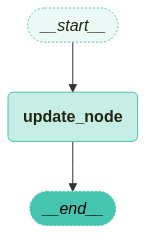

In [10]:
from langchain_teddynote.graphs import visualize_graph
# Initiate Graph add Nodes
_state_update_graph = StateGraph(UpdateState)
_state_update_graph.add_node('update_node',update_node)
_state_update_graph.add_edge(START,"update_node")
_state_update_graph.add_edge("update_node",END)

# 그래프 시각화
state_update_graph = _state_update_graph.compile()
visualize_graph(state_update_graph)


In [11]:
# Execute Graph
from pprint import pprint
init_config = UpdateState(
    {
        "counter":0,
        "flags": {},
        "items": ["A","B"]
        
    }
)
result = state_update_graph.invoke(init_config)
pprint(result)

{'counter': 1,
 'flags': {'node_name': 'update_node', 'processed': True},
 'items': ['A', 'B', 'new_item']}


## 노드의 구성(Configuration)
* 런타임에 노드를 동적으로 조정할 수 있는 메커니즘
* 같은 그래프 구조를 유지하면서 다양한 설정에 따라 처리방식 적용할 수 있음

### RunnableConfig
* LangChain의 핵심 객체
* 노드가 실행될 때 런타임 설정을 전달함
* 동적 유연성을 부여하며, 실행 시점에 다양한 구성 값들을 참조하여 로직 수행

### **구성 접근 및 관리**

* **계층적 구조**
    - `config.get("configurable", {})` 를 통해 사용자 정의 구성에 접근하며, 기본값을 설정해 안정성을 확보함
* **전파 및 상속**
    - 부모 그래프의 구성이 하위 노드로 자동으로 전파되며, 필요에 따라 특정 노드에서 설정을 재정의(오버라이드)할 수 있어 계층적인 관리가 용이함

### **주요 활용 분야**

* **모델 및 매개변수 조정**
  * 런타임에 다른 LLM 모델을 선택하거나, **temperature**, **max_tokens** 같은 매개변수를 동적으로 변경할 수 있음
* **오류 및 재시도 정책**
  * 최대 재시도 횟수나 타임아웃 설정을 환경이나 요청의 중요도에 따라 다르게 적용할 수 있음
* **환경별 설정**
  * 개발, 테스트, 프로덕션 환경에 따라 데이터베이스 연결, API 엔드포인트, 로깅 수준 등을 다르게 설정할 수 있음
* **동적 처리 로직**
  * 구성 값에 따라 간단한 휴리스틱 알고리즘이나 복잡한 AI 모델 등 완전히 다른 처리 방식을 선택하여 성능과 정확도 사이의 균형을 조절할 수 있음
* **사용자별 개인화**
  * 사용자 ID나 권한 레벨을 전달하여 같은 노드라도 사용자별로 다른 데이터 접근 권한이나 처리 방식을 적용할 수 있음
* **성능 최적화**
  * 리소스 환경에 따라 간단하거나 복잡한 모델을 동적으로 선택할 수 있으며, 캐싱, 배치 처리, 병렬 실행 등 최적화 기법을 제어할 수 있음




In [15]:
from langchain_core.runnables import RunnableConfig
class ConfState(TypedDict):
    input:str
    output:str
    config_used:dict

test_config = {
    "configurable": {
        "model": "test",
        "temperature": 0.5,
        "max_retries": 4
    }
}


def configurable_node(
    state:ConfState,
    config:RunnableConfig,
    ) -> Dict[str, Any]:
    """
    구성 가능한 노드
    런타임에 동작을 조정할 수 있음

    Args:
        state: 현재 상태
        config: 런타임 구성
    """
    # 구성에서 값 가져오기
    model_name = config.get("configurable", {}).get("model", "default")
    temperature = config.get("configurable", {}).get("temperature", 0.7)
    max_retries = config.get("configurable", {}).get("max_retries", 3)

    print(f"Using model: {model_name}, temperature: {temperature}")

    # 구성에 따른 처리
    result = None
    for attempt in range(max_retries):
        try:
            result = process_with_model(
                state["input"],
                model=model_name,
                temperature=temperature
            )
            break
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt == max_retries - 1:
                result = "Failed after all retries"

    return {
        "output": result,
        "config_used": {
            "model": model_name,
            "temperature": temperature,
            "retries": max_retries
        }
    }

def process_with_model(
    input_data:str,
    model:str,
    temperature: float
    ):
    """모델을 사용한 처리 (시뮬레이션)"""
    return f"Processed with {model} at temperature {temperature}: {input_data}"


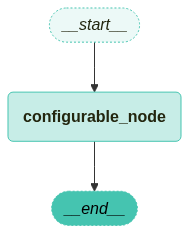

In [16]:
from langchain_teddynote.graphs import visualize_graph
# Initiate Graph add Nodes
_conf_graph = StateGraph(ConfState)
_conf_graph.add_node('configurable_node',configurable_node)
_conf_graph.add_edge(START,"configurable_node")
_conf_graph.add_edge("configurable_node",END)

# 그래프 시각화
conf_graph = _conf_graph.compile()
visualize_graph(conf_graph)


In [17]:
# Execute Graph
from pprint import pprint
init_config = ConfState(
    {
        "input":"hello World!",
        "output": "",
        "config_used":{}
    }
)
result = conf_graph.invoke(input = init_config)
pprint(result)

Using model: default, temperature: 0.7
{'config_used': {'model': 'default', 'retries': 3, 'temperature': 0.7},
 'input': 'hello World!',
 'output': 'Processed with default at temperature 0.7: hello World!'}
